In [124]:
from sandbox.toolbox.models import ResNet112, ResNet56, ResNet20, ResNetBaby
from sandbox.toolbox.factor_transfer_components import Paraphraser, Translator

import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from rich import print as pprint
import os
import glob

device = 'cuda'
plt.rcParams['image.cmap'] = 'magma'

In [2]:
ds = torchvision.datasets.CIFAR100
mean, std = (0.5071, 0.4867, 0.4409), (0.267, 0.256, 0.276) 
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

batch_size = 10 #len(testset)
testset = ds(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=0)
testloader_data = next(iter(testloader))

MODELS = {
    'ResNet112': ResNet112,
    'ResNet56': ResNet56,
    'ResNet20': ResNet20,
    'ResNetBaby': ResNetBaby
}

current = {}

root_dir = "experiments-24-03"
pth_files = glob.glob(os.path.join(root_dir, "**/Cifar100_ResNet*.pth"), recursive=True)

for file_path in pth_files:
    split = file_path.split('\\')[1:]
    run_number, distillation_type = (split[2], 'None') if split[2].isdigit() else (split[3], split[2])
    model_name = split[1].split('_')[0] 
    if model_name == 'ResNet56' and distillation_type == 'ft' and run_number == '1':
        model = MODELS[model_name](100).to(device)
        checkpoint = torch.load(file_path, weights_only=True)
        model.load_state_dict(checkpoint['weights'])
        current[f'{model_name}_{distillation_type}'] = model
        print(f'Loaded: {model_name}-{distillation_type}')


Files already downloaded and verified
Loaded: ResNet56-ft


In [33]:
inputs, targets = testloader_data 
inputs, targets = inputs.to(device), targets.to(device)
rn56 = current['ResNet56_ft']
rn56.eval()
with torch.no_grad():
    outputs = rn56(inputs)
probs = torch.nn.functional.softmax(outputs[3], dim=1)
confidence, predicted = torch.max(probs.data, 1)

batch = [{
    'feature_map':outputs[2][i],
    'correct': predicted.eq(targets.data).cpu().float()[i].item() == 1.0,
    'predicted_class': np.array(testloader.dataset.classes)[predicted.data.cpu()][i],
    'correct_class': np.array(testloader.dataset.classes)[targets.data.cpu()][i],
    'confidence': confidence[i].item()
} for i in range(10)]

# for i in range(10):
    # feature_map = thing[i]['feature_map'][0].cpu() 
    # predicted = thing[i]['predicted_class']
    # plt.matshow(feature_map)
    # print(f'First channel of final feature map of the {i}th sample ({predicted}) out of the dataset')
    # plt.show()

batch[1]['feature_map'].shape

torch.Size([64, 8, 8])

In [ ]:
def print_sample_data(index, batch):
    batch_sample = batch[index]
    print(batch_sample['correct'], '| Predicetd', batch_sample['predicted_class'], '| Actual', batch_sample['correct_class'], ' | Confidence', f'{batch_sample['confidence'] * 100:.2f}%')

def show_sample(index):
    images, labels = testloader_data
    img = images[index]
    img = img * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
    img = img.permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def process_feature_map(feature_map):
    fmap = feature_map.unsqueeze(0).cpu()  # Shape: [1, C, H, W]
    fmap_avg = torch.mean(fmap, dim=1, keepdim=True)  # Shape: [1, 1, H, W]
    batch_size, _, h, w = fmap_avg.shape
    fmap_flat = fmap_avg.view(batch_size, -1)  # Shape: [1, H*W]
    tau = 0.5
    fmap_scaled = fmap_flat / tau
    fmap_softmax = torch.softmax(fmap_scaled, dim=1)  # Shape: [1, H*W]
    fmap_softmax = fmap_softmax * (h * w)  # Scale by H*W
    fmap_processed = fmap_softmax.view(1, 1, h, w)  # Shape: [1, 1, H, W]
    return fmap_processed[0, 0].unsqueeze(0).unsqueeze(0).to(device)

def visualize_processed_feature_map(index, batch):
    plt.figure(figsize=(5, 5))
    feature_map = batch[index]['feature_map']
    processed_fmap = process_feature_map(feature_map)[0,0].cpu()
    plt.imshow(processed_fmap, vmin=0)
    plt.axis('off')
    plt.title(f'Processed Feature Map for sample {index}')
    plt.show()

def visualize_channels(index, batch):
    fig, axs = plt.subplots(8, 8,figsize=(5,5))  
    feature_map = batch[index]['feature_map']
    for i in range(8):
        for j in range(8):
            # axs[i, j*8].matshow(feature_map[i+j*8].cpu(), vmin=0)
            axs[i,j].matshow(feature_map[i+j*8].cpu(), vmin=0)
            axs[i,j].axis('off')
    plt.tight_layout()
    plt.show()

In [116]:
inputs, targets = testloader_data 
inputs, targets = inputs.to(device), targets.to(device)
rn56 = current['ResNet56_ft']
rn56.eval()
with torch.no_grad():
    outputs = rn56(inputs)

bfmap = outputs[2]

In [ ]:
paraphraser_compression = 0.5
# Paraphraser = Paraphraser(64, int(round(64*paraphraser_compression))).to(device)
translator = Translator(64, 32).to(device)
checkpoint = torch.load('translator.pth', weights_only=True)
translator.load_state_dict(checkpoint['weights'])
translator.eval()

factor_s = translator(bfmap)
print(factor_s.shape)
# plt.matshow(factor_s[0,2].cpu().detach())
# plt.show()
# plt.matshow(bfmap[0,2].cpu())
# plt.show()


sample_idx = 1 # random.randint(0,9999)
show_sample(sample_idx)
print_sample_data(sample_idx, batch)
print('NORMAL')
visualize_processed_feature_map(sample_idx, batch)
visualize_channels(sample_idx, batch)


print('PROCESSED')
plt.figure(figsize=(5, 5))
feature_map = factor_s[sample_idx]
print(feature_map.shape)
processed_fmap = process_feature_map(feature_map)[0,0].cpu().detach()
plt.imshow(processed_fmap, vmin=0)
plt.axis('off')
plt.title(f'Processed Feature Map for sample {sample_idx}')
plt.show()


fig, axs = plt.subplots(8, 4,figsize=(5,5))  
feature_map = factor_s[sample_idx]
for i in range(8):
    for j in range(4):
        axs[i,j].matshow(feature_map[i+j*4].cpu().detach(), vmin=0)
        axs[i,j].axis('off')
plt.tight_layout()
plt.show()


tded.shape=torch.Size([10, 64, 8, 8])
True | Predicetd can | Actual can  | Confidence 99.89%
NORMAL


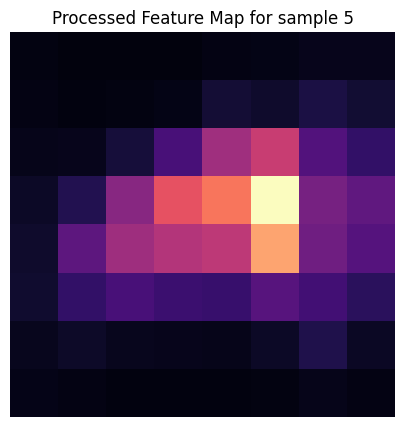

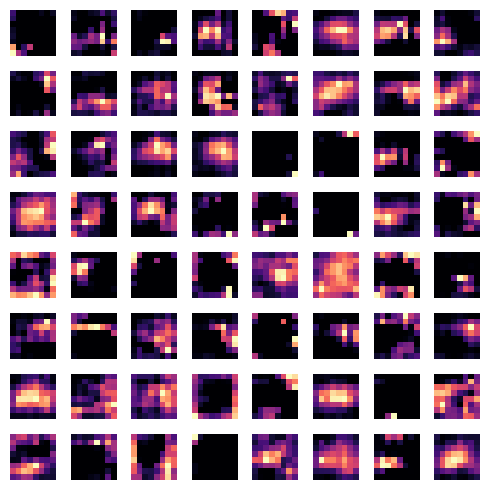

PROCESSED


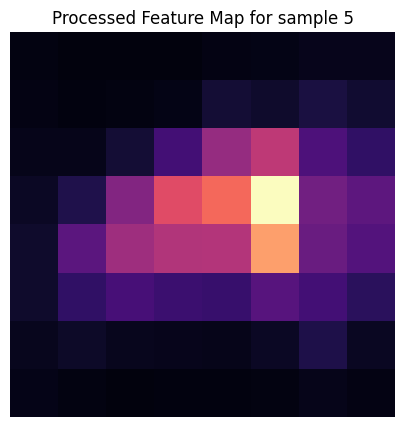

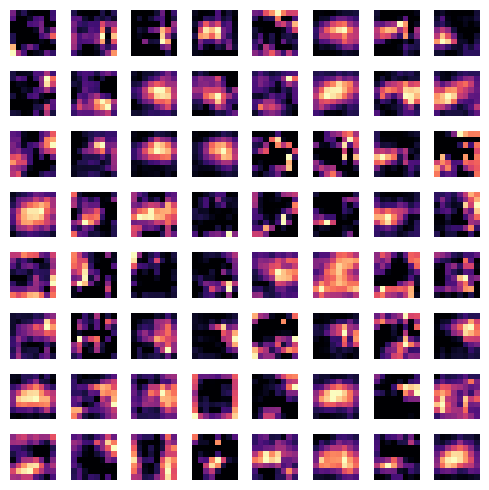

In [178]:
import tensorly as tl
tl.set_backend('pytorch')
def tucker_decomposition(feature_maps, rank):
    batch_size, num_channels, height, width = feature_maps.shape
    ranks = [batch_size, rank, height, width]

    core, factors = tl.decomposition.tucker(
        feature_maps, rank=ranks)

    x_reconstructed = tl.tucker_to_tensor((core, factors))
    x_reconstructed = x_reconstructed.to(feature_maps.device)

    return x_reconstructed

tded = tucker_decomposition(bfmap,32)
print(f'{tded.shape=}')

sample_idx = 5 
bfmap = outputs[2]
# show_sample(sample_idx)
print_sample_data(sample_idx, batch)
print('NORMAL')
visualize_processed_feature_map(sample_idx, batch)
visualize_channels(sample_idx, batch)




print('PROCESSED')
plt.figure(figsize=(5, 5))
feature_map = tded[sample_idx]
processed_fmap = process_feature_map(feature_map)[0,0].cpu().detach()
plt.imshow(processed_fmap, vmin=0)
plt.axis('off')
plt.title(f'Processed Feature Map for sample {sample_idx}')
plt.show()


fig, axs = plt.subplots(8, 8,figsize=(5,5))  
feature_map = tded[sample_idx]
for i in range(8):
    for j in range(8):
        axs[i,j].matshow(feature_map[i+j*8].cpu().detach(), vmin=0)
        axs[i,j].axis('off')
plt.tight_layout()
plt.show()


In [ ]:



plt.figure(figsize=(5, 5))
feature_map = factor_s[sample_idx]
print(feature_map.shape)
processed_fmap = process_feature_map(feature_map)[0,0].cpu().detach()
plt.imshow(processed_fmap, vmin=0)
plt.axis('off')
plt.title(f'Processed Feature Map for sample {sample_idx}')
plt.show()


fig, axs = plt.subplots(8, 4,figsize=(5,5))  
feature_map = factor_s[sample_idx]
for i in range(8):
    for j in range(4):
        axs[i,j].matshow(feature_map[i+j*4].cpu().detach(), vmin=0)
        axs[i,j].axis('off')
plt.tight_layout()
plt.show()

False | Predicetd rose | Actual maple_tree  | Confidence 29.07%


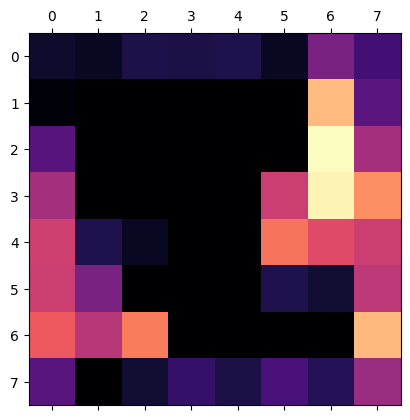

In [ ]:
sample_idx = 2 # random.randint(0,9999)
# show_sample(sample_idx)
print_sample_data(sample_idx, batch)
# visualize_processed_feature_map(sample_idx, batch)
# visualize_channels(sample_idx, batch)
